# Principle Component Analysis

This document is based on: [Principal Component Analysis from Scratch](https://bagheri365.github.io/blog/Principal-Component-Analysis-from-Scratch/)

There are some differences: 
- svd decomposition of the covariance matrix is used instead of the Eigen decomposition. Thus, the Eigen value and vector pairs are always in non-ascending order.
- Additional Eigen value correction is an optional step which is needed to obtain identical results with scikit-learn.

## What is PCA?

Greenacre, M., Groenen, P.J.F., Hastie, T. et al. Principal component analysis. Nat Rev Methods Primers 2, 100 (2022):
* PCA reduces a cases-by-variables data table to its essential features, called principal components. 
* Principal components are a few linear combinations of the original variables that maximally explain the variance of all the variables. 
* The method provides an approximation of the original data table using only these few major components.
    

## Preparations

In [2]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.size": 8,
})

## Iris Dataset

The iris data is ideal for our learning purpose since the data has only 4 features: `sepal-length`, `sepal-width`, `petal-length`, and `petal-width`.

In [3]:
data = np.loadtxt("./datasets/iris/iris.data", delimiter=",", dtype=str)
X = np.float32(data[:, 0:4])  # 4 features

# Change the labels: string labels to numerical labels:
# Iris-setosa     = 0
# Iris-versicolor = 1
# Iris-virginica  = 2
y = np.zeros(X.shape[0], dtype=np.int32) 
y[np.where(data[:,-1]=='Iris-setosa')]     = 0
y[np.where(data[:,-1]=='Iris-versicolor')] = 1
y[np.where(data[:,-1]=='Iris-virginica')]  = 2

feature_names = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width']
n_features = X.shape[1]

print("Feature numbers :", X.shape[1])
print("Number of data  :", X.shape[0])
print("Labels          :", np.unique(y))

Feature numbers : 4
Number of data  : 150
Labels          : [0 1 2]


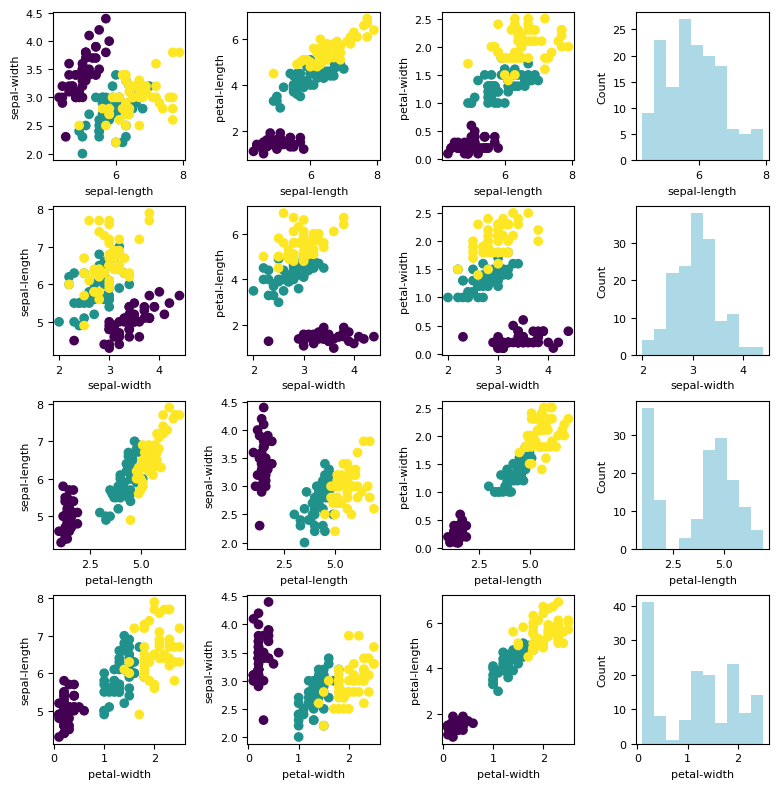

In [4]:
%matplotlib inline

fig, ax = plt.subplots(nrows=n_features, ncols=n_features, figsize= (8, 8))
fig.tight_layout(pad=2.0)

names = feature_names

for i in range(n_features):
    J = np.arange(n_features)
    J = np.delete(J, i)
    for k, j in enumerate(J):
        ax[i, k].scatter(X[:, i], X[:, j], c = y)
        ax[i, k].set_xlabel(names[i])
        ax[i, k].set_ylabel(names[j])
        
for i in range(n_features):
    ax[i, -1].hist(X[:, i], color = 'lightblue')
    ax[i, -1].set_ylabel('Count')
    ax[i, -1].set_xlabel(names[i])

### Standardization

Definition:

$$ \mathrm{X}^{\prime}=\frac{\mathrm{X}-\text { Mean }}{\text { Standard deviation }} $$

In [5]:
means  = np.mean(X, axis=0)
stdevs = np.std(X, axis=0)

X_std = (X - means) / stdevs

Let us plot the standardized dataset.

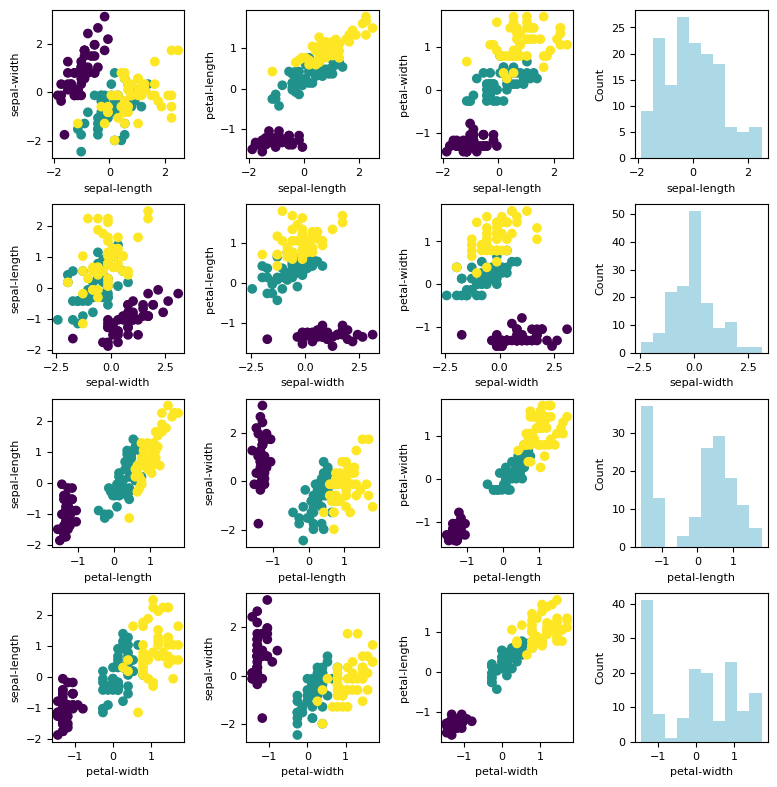

In [6]:
%matplotlib inline

fig, ax = plt.subplots(nrows=n_features, ncols=n_features, figsize= (8, 8))
fig.tight_layout(pad=2.0)

names = feature_names

for i in range(n_features):
    J = np.arange(n_features)
    J = np.delete(J, i)
    for k, j in enumerate(J):
        ax[i, k].scatter(X_std[:, i], X_std[:, j], c = y)
        ax[i, k].set_xlabel(names[i])
        ax[i, k].set_ylabel(names[j])
        
for i in range(n_features):
    ax[i, -1].hist(X_std[:, i], color = 'lightblue')
    ax[i, -1].set_ylabel('Count')
    ax[i, -1].set_xlabel(names[i])

### Covariance matrix

Defintion:

$$\left[\begin{array}{cccc}\operatorname{Var}\left(x_1\right) & \cdots & \operatorname{Cov}\left(x_{n}, x_1\right) \\ \vdots & \ddots & & \vdots \\ \vdots & \ddots & \vdots \\ \operatorname{Cov}\left(x_{n,}, x_1\right) & \cdots & \operatorname{Var}^2\left(x_{n}\right)\end{array}\right]$$

where:

$$\operatorname{Cov}(x, y)=\frac{\sum(x-\bar{x})(y-y)}{N-1}$$

and

$$\operatorname{Var}(x)=\frac{\sum(x-\bar{x})^2}{N-1}$$

In [7]:
cov_mat = np.cov(X_std.T) # square symmetric, positive semi-definite
cov_mat

array([[ 1.00671194, -0.11010332,  0.87760527,  0.82344337],
       [-0.11010332,  1.00671113, -0.4233384 , -0.35893692],
       [ 0.87760527, -0.4233384 ,  1.00671182,  0.96921862],
       [ 0.82344337, -0.35893692,  0.96921862,  1.00671115]])

### Singular Value Decompostion

Defintion:

$$ A=U \Sigma V^T$$

For square symmetric positive semi-definite matrix (such as covariance matrix), the eigenvalues and $\operatorname{diag}(\Sigma)$ are exactly the same and $U$ is the Eigen-vector matrix.

In [8]:
U, S, Vh = np.linalg.svd(cov_mat)
eig_vals = S
eig_vecs = U

print(S)
print()
print(U)

[2.93035432 0.92740345 0.14834225 0.02074602]

[[-0.52237175 -0.37231839  0.72101672  0.26199553]
 [ 0.2633548  -0.9255565  -0.24203298 -0.12413483]
 [-0.58125407 -0.02109465 -0.14089245 -0.80115419]
 [-0.56561092 -0.06541562 -0.63380142  0.52354641]]


### Correct the Eigen Matrix

__This section is actually optional. This step is necessary if we want to keep our results identical to PCA from scikit-learn.__

Correct the Eigen matrix such that:
* for each column, find the __largest absolute__ value
* if the __largest absolute__ value comes from a negative value, make it positive by multiplying the entire column with -1

In [9]:
from numpy.linalg import eig

# Adjusting the eigenvectors (loadings) that are largest in absolute value to be positive
max_abs_idx = np.argmax(np.abs(eig_vecs), axis=0)
signs = np.sign(eig_vecs[max_abs_idx, range(eig_vecs.shape[0])])
eig_vecs_ = eig_vecs*signs[np.newaxis,:]

print(eig_vals)
print()
print(eig_vecs_)

[2.93035432 0.92740345 0.14834225 0.02074602]

[[ 0.52237175  0.37231839  0.72101672 -0.26199553]
 [-0.2633548   0.9255565  -0.24203298  0.12413483]
 [ 0.58125407  0.02109465 -0.14089245  0.80115419]
 [ 0.56561092  0.06541562 -0.63380142 -0.52354641]]


### Select the Axis Components

In [10]:
# Select top k eigenvectors
k = 2
W = eig_vecs_[:, :k] # Projection matrix
print(W)
print(W.shape)

[[ 0.52237175  0.37231839]
 [-0.2633548   0.9255565 ]
 [ 0.58125407  0.02109465]
 [ 0.56561092  0.06541562]]
(4, 2)


### Transform the Dataset

In [11]:
X_proj = X_std.dot(W)
print(X_proj.shape)

(150, 2)


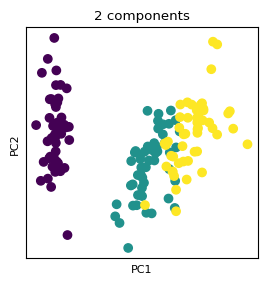

In [12]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(3,3))

ax.scatter(X_proj[:, 0], X_proj[:, 1], c = y)
ax.set_xlabel('PC1'); plt.xticks([])
ax.set_ylabel('PC2'); plt.yticks([])
ax.set_title('2 components');

### Explained Variance

The optimal value for `k` can be tuned by investigating the explained variance. 

The explained variance tells us how much information (variance) can be attributed to each of the principal components.

$$
\text{Explained variance} = \frac{\sum_{i=0}^{r} \lambda_i}{\sum_{i=0}^{m} \lambda_i} = \frac{\lambda_1 + \lambda_2 + \cdots + \lambda_m}{\lambda_1 + \lambda_2 + \cdots + \lambda_r}
$$

where: $r<= m$ 

Explained variance: [72.77 23.03  3.68  0.52]
Cumulative explained variance: [ 72.77  95.8   99.48 100.  ]


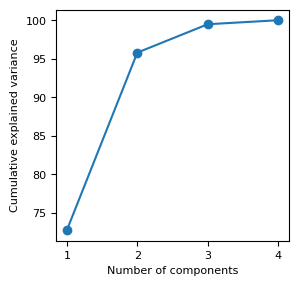

In [13]:
%matplotlib inline

eig_vals_total = sum(eig_vals)
explained_variance = [(i / eig_vals_total)*100 for i in eig_vals]
explained_variance = np.round(explained_variance, 2)
cum_explained_variance = np.cumsum(explained_variance)

print('Explained variance: {}'.format(explained_variance))
print('Cumulative explained variance: {}'.format(cum_explained_variance))

fig, ax = plt.subplots(figsize= (3, 3))

ax.plot(np.arange(1,n_features+1), cum_explained_variance, '-o')
ax.set_xticks(np.arange(1,n_features+1))
ax.set_xlabel('Number of components')
ax.set_ylabel('Cumulative explained variance');

## References:

* [Principal Component Analysis from Scratch](https://bagheri365.github.io/blog/Principal-Component-Analysis-from-Scratch/)
* [Principal component analysis. Nat Rev Methods Primers 2, 100 (2022)](https://pure.eur.nl/ws/portalfiles/portal/95076086/Nature_Reviews_Methods_Primer_Greenacre_et_al_2022_PCA.pdf)
* [MIT OCW, Statistics for Applications, Chapter 9: Principal Component Analysis (PCA)](https://ocw.mit.edu/courses/18-650-statistics-for-applications-fall-2016/d85e1a9d113142ade8ce5e4f5ef0b4e8_MIT18_650F16_PCA.pdf)